In [1]:
import dynamo as dyn 
import scvelo as scv
import numpy as np 
from scipy.spatial.distance import euclidean 
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix
from collections import Counter
import re
from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd
import scvelo as scv
from kneed import KneeLocator
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

/home/dap182/anaconda3/envs/kb/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
adata=dyn.read_loom('data/a549_tgfb1.loom')
meta=pd.read_csv('data/a549_tgfb1_meta.csv')
adata

AnnData object with n_obs × n_vars = 3567 × 33694 
    obs: 'Clusters', '_X', '_Y', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [5]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
adata

AnnData object with n_obs × n_vars = 3567 × 33694 
    obs: 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [7]:
CellIDs=np.array(meta["Unnamed: 0"])+'x'
for ID in range(len(CellIDs)):
    #This is needed to make the cell ids have the same syntax as the loom files 
    CellIDs[ID]=re.sub('x',"x-",CellIDs[ID],count=1)
    CellIDs[ID]=re.sub('_',":",CellIDs[ID])

meta['Unnamed: 0']=CellIDs

cells=meta['Unnamed: 0'].to_numpy()

treatment=np.array([[meta['Time'][np.squeeze(np.argwhere(cells==cell))]][0] for cell in adata.obs_names])

adata.obs['treatment']=treatment

adata

AnnData object with n_obs × n_vars = 3567 × 33694 
    obs: 'Clusters', '_X', '_Y', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [23]:
count_matrix=adata.X.todense()
velocity_matrix=adata.layers['velocity']

count_pca=PCA(n_components=100,random_state=0).fit(count_matrix)
velocity_pca=PCA(n_components=100,random_state=0).fit(velocity_matrix)

count_pcs=count_pca.transform(count_matrix)
velocity_pcs=velocity_pca.transform(velocity_matrix)

<BarContainer object of 100 artists>

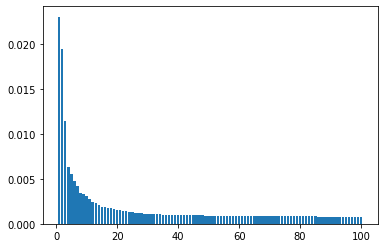

In [24]:
plt.bar(np.arange(1,101),count_pca.explained_variance_ratio_)

<BarContainer object of 100 artists>

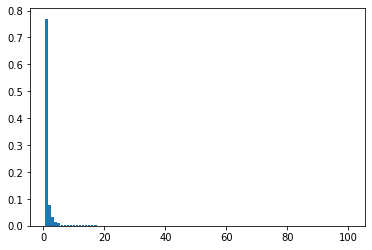

In [27]:
plt.bar(np.arange(1,101),velocity_pca.explained_variance_ratio_)

In [26]:
print('variance explained by first 100 pcs in count matrix is',np.sum(count_pca.explained_variance_ratio_[:100]))
print('variance explained by first 100 pcs in velocity matrix is',np.sum(velocity_pca.explained_variance_ratio_[:100]))

variance explained by first 100 pcs in count matrix is 0.17889184
variance explained by first 100 pcs in velocity matrix is 0.9597185


In [31]:
X=count_pcs

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,50) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(X) 
    kmeanModel.fit(X)     
        
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


12


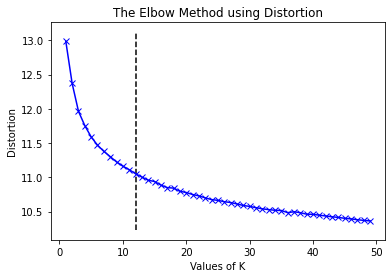

In [32]:
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
print(kn.knee) 

plt.plot(K, distortions, 'bx-') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [35]:
knee=kn.knee
X=count_pcs

kmeans = KMeans(n_clusters=knee,random_state=0).fit(X) 

In [36]:
cluster_centers=kmeans.cluster_centers_

labels=kmeans.labels_

label=0

boolean_list=np.argwhere(labels==label).squeeze()

count_cluster_members=count_pcs[boolean_list]
velocity_cluster_members=velocity_pcs[boolean_list]

In [37]:
X=count_cluster_members
y=velocity_cluster_members

model=LinearRegression().fit(X,y)

In [41]:
model.coef_.shape

(100, 100)